<a href="https://colab.research.google.com/github/lc0/deeplearning-playground/blob/master/TF2/tf2_tiff_images_dataset_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-nightly-gpu-2.0-preview

# Data

## initial training dataset

In [0]:
from google.colab import files

uploaded = files.upload()

Saving photomask_trainingdata.zip to photomask_trainingdata.zip


In [2]:
!ls -la

total 5572
drwxr-xr-x 1 root root    4096 Feb 10 14:57 .
drwxr-xr-x 1 root root    4096 Feb 10 14:50 ..
drwxr-xr-x 1 root root    4096 Feb  6 17:30 .config
drwxr-xr-x 3 root root    4096 Feb 10 14:57 dataset
-rw-r--r-- 1 root root 2430745 Feb 10 14:54 photomask_testdata.zip
-rw-r--r-- 1 root root 3249054 Feb 10 14:56 photomask_trainingdata.zip
drwxr-xr-x 1 root root    4096 Feb  6 17:31 sample_data


In [0]:
!unzip photomask_trainingdata.zip -d dataset

In [0]:
rm -r dataset/__MACOSX/

In [0]:
dataset_path = 'dataset/photomask_trainingdata/'

In [4]:
!ls -la {dataset_path}

total 20
drwxrwxrwx 5 root root 4096 Feb  5 17:17  .
drwxr-xr-x 3 root root 4096 Feb 10 14:57  ..
drwxrwxrwx 2 root root 4096 Feb  5 17:04  BORDERTOUCHER
drwxrwxrwx 2 root root 4096 Feb  5 17:05 'COMPLETE FEATURE'
drwxrwxrwx 2 root root 4096 Feb  5 17:04 'NO FEATURE'


## TF Dataset based on the files

In [5]:
import tensorflow as tf

tf.version.VERSION

'2.0.0-dev20190208'

In [0]:
work_image_size = [28, 28]

batch_size = 16

In [0]:
from os import listdir, path

class_names = listdir(dataset_path)
# print(class_names)

class_folders = [(idx, path.join(dataset_path, class_name)) for idx, class_name in enumerate(class_names)]
# print(class_folders)

In [8]:
filenames = []
class_ids = []
for class_id, folder in class_folders:
  files = listdir(folder)
  
  filenames.extend([path.join(folder, filename) for filename in listdir(folder)])
  class_ids.extend([class_id for filename in listdir(folder)])


print(len(filenames))
assert len(class_ids) == len(class_ids)

111


Unfortunately `tf.py_function` can only return a tuple. With generic `map` we can work with `dict` interface

In [0]:
from PIL import Image
import numpy as np

def parse_tiff_py(filename, class_id):
    print(filename.numpy())
    
    im = Image.open(filename.numpy())
    im = im.resize(work_image_size)
    
    return np.array(im), class_id

Now we just need to add our python function to `dataset` pipeline. We can do with follow `lambda` trick

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((filenames, class_ids))
dataset = dataset.shuffle(len(filenames))

dataset = dataset.map(lambda filename, label: tf.py_function(
              parse_tiff_py, 
              (filename, label),  
              [tf.uint8, label.dtype]))

dataset

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.uint8, tf.int32)>

In [11]:
for row in dataset.take(1):
  print(row)
  image = row[0]
  label = row[1]

b'dataset/photomask_trainingdata/COMPLETE FEATURE/028_2.tif'
(<tf.Tensor: id=28, shape=(28, 28), dtype=uint8, numpy=
array([[151, 151, 172, 153, 148, 155, 149, 157, 147, 150, 148, 167, 147,
        163, 172, 151, 192, 156, 158, 163, 167, 169, 153, 149, 154, 130,
        174, 143],
       [173, 152, 166, 186, 164, 136, 141, 164, 178, 130, 172, 168, 156,
        194, 166, 174, 165, 157, 164, 153, 174, 171, 136, 151, 161, 160,
        152, 172],
       [147, 141, 161, 156, 169, 177, 143, 165, 171, 153, 145, 153, 196,
        156, 166, 152, 156, 167, 151, 175, 172, 138, 169, 169, 132, 179,
        162, 165],
       [187, 148, 160, 138, 144, 162, 167, 154, 150, 160, 161, 156, 144,
        145, 181, 158, 152, 197, 154, 151, 181, 177, 158, 138, 196, 164,
        176, 170],
       [139, 143, 142, 155, 182, 164, 166, 166, 149, 147, 151, 134, 144,
        150, 166, 171, 177, 137, 162, 165, 188, 150, 153, 152, 148, 154,
        157, 160],
       [167, 177, 172, 170, 153, 150, 172, 161, 151, 141, 

(28, 28)
Label - COMPLETE FEATURE


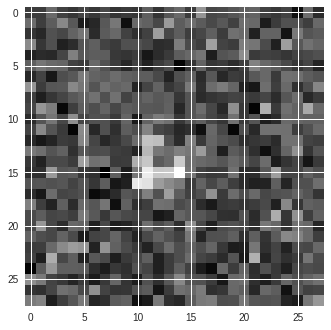

In [12]:
import matplotlib.pyplot as plt

print(image.shape)
plt.imshow(image, cmap=plt.get_cmap("gray"))

print(f"Label - {class_names[label]}")